# CNN for Classification
---
In this notebook, we define **and train** an CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [2]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

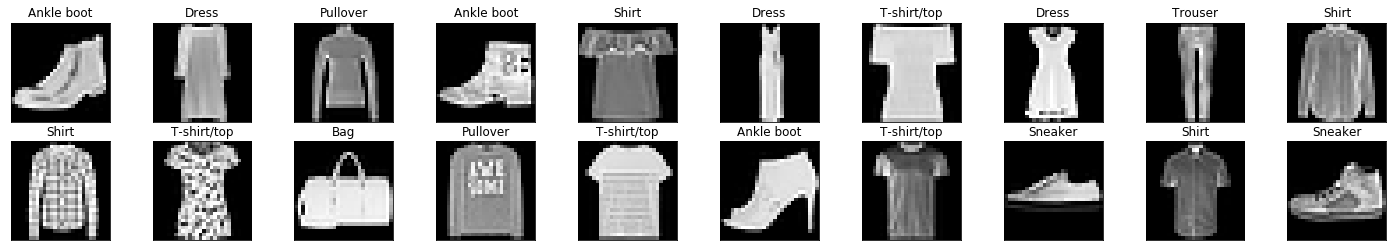

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

### TODO: Define the Net

Define the layers of your **best, saved model from the classification exercise** in the function `__init__` and define the feedforward behavior of that Net in the function `forward`. Defining the architecture here, will allow you to instantiate and load your best Net.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # size of output: (28-3)/1 + 1 ==> (10, 26, 26), after pooling: (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting

        # 10 input image channel (outputs from previous layer), 30 output channels/feature maps, 3x3 square convolution kernel
        # size of output: (13-3)/1+1 ==> (20, 11, 11), after pooling: (20, 5, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)

        # maxpool that uses a square window of kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)    

        # 20 outputs * the 5*5 filtered/pooled map size
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)

    ## TODO: define the feedforward behavior
    def forward(self, x):
        # two pooled/activated conv layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # one linear layer
        x = self.fc1(x)
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)

        # final output
        return x

### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters. This notebook needs to know the network architecture, as defined above, and once it knows what the "Net" class looks like, we can instantiate a model and load in an already trained network.

You should have a trained net in `saved_models/`.


In [12]:
# instantiate your Net
net = Net()

# load the net parameters by name, uncomment the line below to load your model
net.load_state_dict(torch.load('saved_models/model_mine.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


## Feature Visualization

To see what your network has learned, make a plot of the learned image filter weights and the activation maps (for a given image) at each convolutional layer.

### TODO: Visualize the learned filter weights and activation maps of the convolutional layers in your trained Net

Choose a sample input image and apply the filters in every convolutional layer to that image to see the activation map.

First convolutional layer


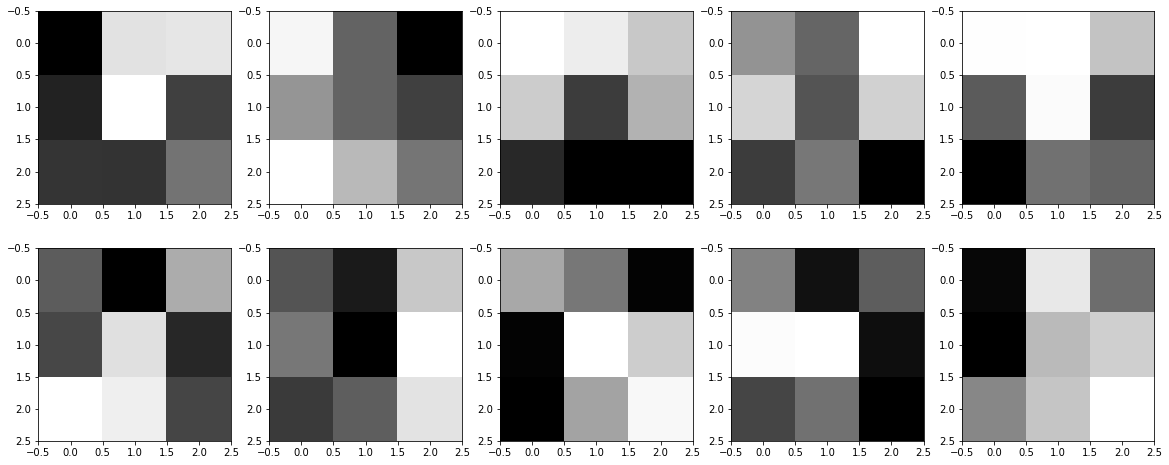

In [14]:
# As a reminder, here is how we got the weights in the first conv layer (conv1), before
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

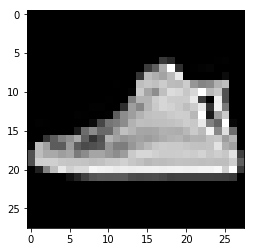

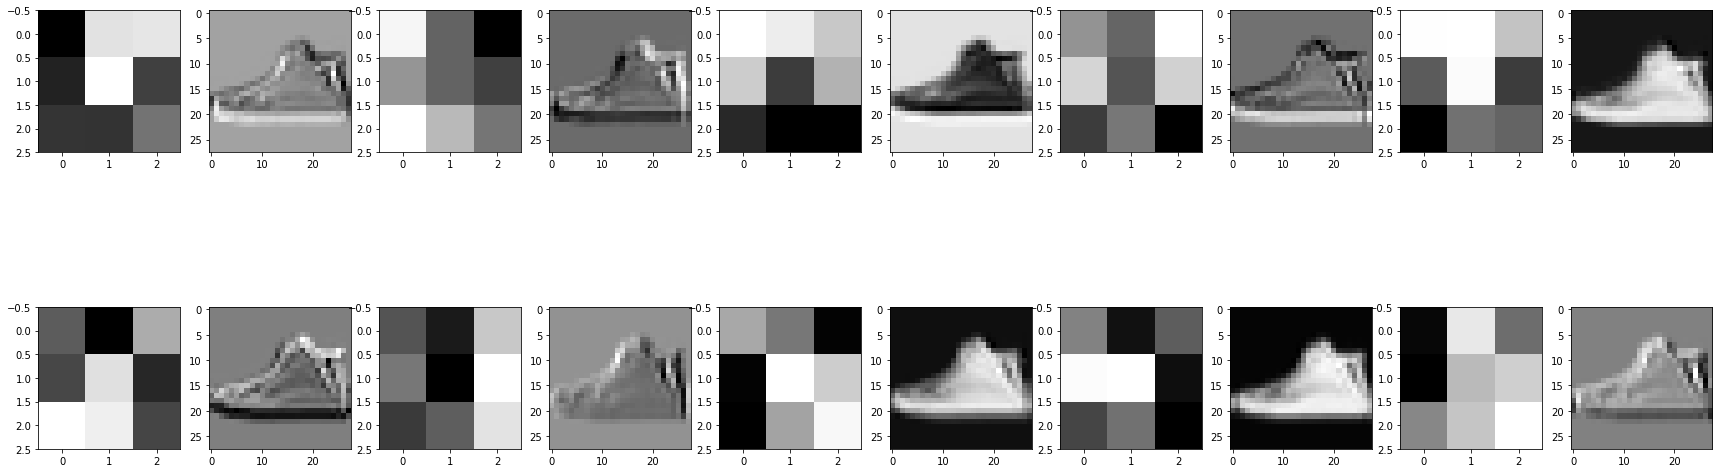

In [15]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 10
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question: Choose a filter from one of your trained convolutional layers; looking at these activations, what purpose do you think it plays? What kind of feature do you think it detects?
